Importing Walid's calculation of the scattering parameters of the combination of coaxial adapter and impedance transformer

In [122]:
%matplotlib notebook

In [123]:
from scipy.io.matlab import loadmat
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt

In [209]:
# This is the chain matrix (ABCD) of the error box, Port 1 is 50ohm side, Port 2 is 30ohm 9inch side
error_adapter = loadmat('Error Adapter/T_errorbox.mat')
error_adapter

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jan 11 12:16:14 2019',
 '__version__': '1.0',
 '__globals__': [],
 'T11': array([[ 0.83816247-2.95942523e-10j,  0.84324803+0.00000000e+00j,
          0.84834366+3.59127990e-16j, ..., -0.14844734+2.92271134e-16j,
         -0.14844734+2.92271134e-16j, -0.14844734+2.92271134e-16j]]),
 'T12': array([[ 5.66741113e-09-30.79138879j,  0.00000000e+00-30.68287893j,
         -6.89525741e-15-30.57947027j, ..., -2.17926438e-15+39.10265269j,
         -2.17926438e-15+39.10265269j, -2.17926438e-15+39.10265269j]]),
 'T21': array([[ 7.52828755e-12-0.02025971j,  0.00000000e+00-0.02015499j,
         -4.48909987e-18-0.0200479j , ..., -7.09395956e-19+0.02504893j,
         -7.09395956e-19+0.02504893j, -7.09395956e-19+0.02504893j]]),
 'T22': array([[ 0.44880969-2.55087439e-10j,  0.4525203 -7.21382839e-17j,
          0.45611908+1.07738397e-16j, ..., -0.13823327+1.53229527e-16j,
         -0.13823327+1.53229527e-16j, -0.13823327+1.53229527e

In [266]:
# converting the ABCD matrix into skrf Network
A11 = error_adapter['T11'].squeeze()
A12 = error_adapter['T12'].squeeze()
A21 = error_adapter['T21'].squeeze()
A22 = error_adapter['T22'].squeeze()

# creating a (2,2) matrix for all the N frequencies (2,2,N)
# pays attention that A21 is volontary transposed with A12
# in order to be at the correct position after swaping the axes after
# (1st dimension in Numpy along rows!)
A = np.array([[A11, A21],
              [A12, A22]])
# (2,2,N) -> (N,2,2) 
A = A.swapaxes(2,0)

# transforming to S matrices
S = rf.network.a2s(A, z0=50)

# converting the transmission parameters to skrf Network
freq = rf.Frequency.from_f(error_adapter['fMHz'].squeeze(), unit='MHz')
err = rf.Network(s=S, frequency=freq, z0=50, name="error adapter")


<IPython.core.display.Javascript object>


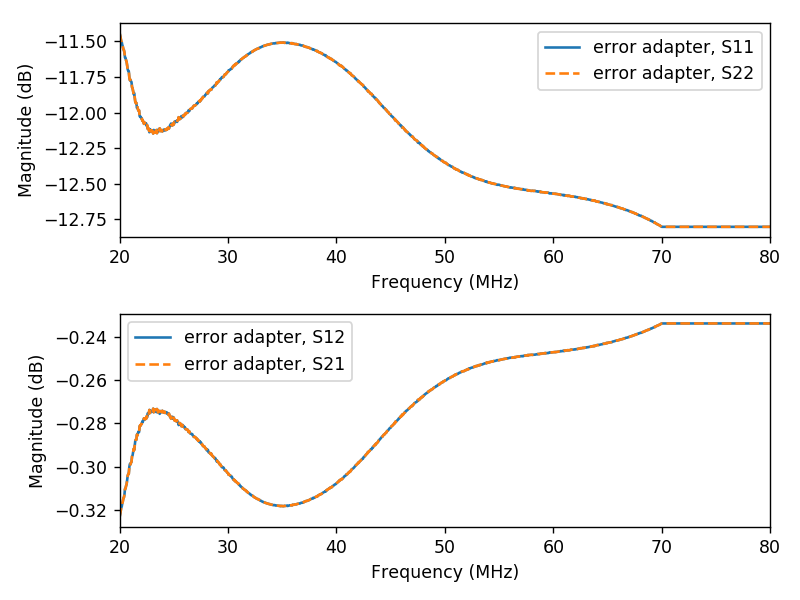

In [276]:
fig, axes = plt.subplots(2,1)
err.plot_s_db(ax=axes[0], m=0, n=0)
err.plot_s_db(ax=axes[0], m=1, n=1, ls='--')

err.plot_s_db(ax=axes[1], m=0, n=1)
err.plot_s_db(ax=axes[1], m=1, n=0, ls='--')
fig.tight_layout()

<IPython.core.display.Javascript object>


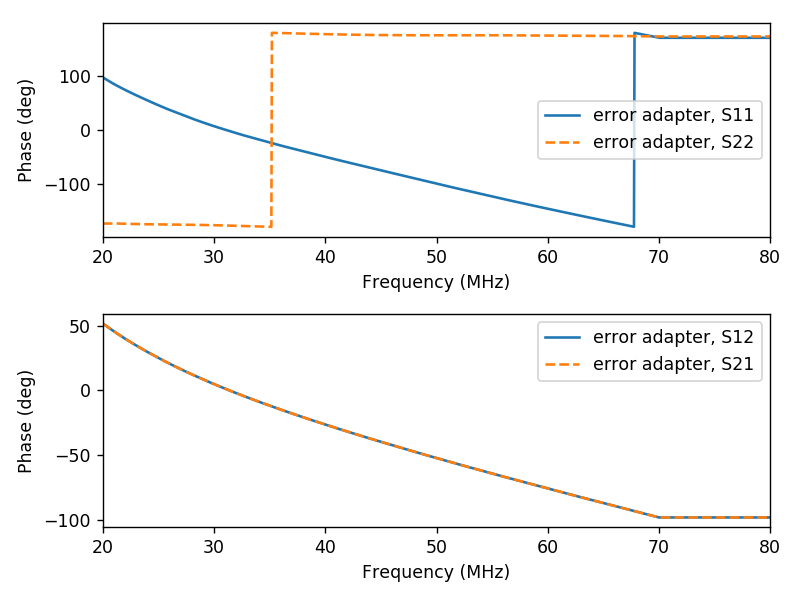

In [277]:
fig, axes = plt.subplots(2,1)
err.plot_s_deg(ax=axes[0], m=0, n=0)
err.plot_s_deg(ax=axes[0], m=1, n=1, ls='--')

err.plot_s_deg(ax=axes[1], m=0, n=1)
err.plot_s_deg(ax=axes[1], m=1, n=0, ls='--')
fig.tight_layout()

In [301]:
x11 = np.array([0,1,2,3])
x12 = np.array([10,11,12,13])
x21 = np.array([20,21,22,23])
x22 = np.array([30,31,32,33])

x=np.array([[x11, x12], [x21, x22]])

print(x)

print(x.swapaxes(2,0))

[[[ 0  1  2  3]
  [10 11 12 13]]

 [[20 21 22 23]
  [30 31 32 33]]]
[[[ 0 20]
  [10 30]]

 [[ 1 21]
  [11 31]]

 [[ 2 22]
  [12 32]]

 [[ 3 23]
  [13 33]]]


In [297]:
np.array([[x11, x12], [x21, x22]])

array([[[ 0,  1,  2,  3],
        [10, 11, 12, 13]],

       [[20, 21, 22, 23],
        [30, 31, 32, 33]]])